In [52]:
import base64
import io
import os
import re

import pandas as pd
import tensorflow as tf
import torch
from byaldi import RAGMultiModalModel
from byaldi.colpali import ColPaliModel
from onnxruntime.capi import _pybind_state as C

print(f"Torch CUDA available: {torch.cuda.is_available()}")
print(f"TF CUDA available: {tf.test.is_built_with_cuda()}")
print(f"Available ONNXRT providers: {C.get_available_providers()}")

Torch CUDA available: True
TF CUDA available: True
Available ONNXRT providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [56]:
os.chdir("/tmp/pycharm_project_869/playgrounds")

In [63]:

from tools import cache_tool
from qwen_vl_utils import process_vision_info
import os
import srsly
import torch
import shutil
from typing import Optional, Union, List, Dict
from pathlib import Path
from PIL import Image
from pdf2image import convert_from_path
from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from byaldi.objects import Result
from byaldi.utils import capture_print
# Import version directly from the package metadata
from importlib.metadata import version

VERSION = version("Byaldi")

MOCK_IMAGE = Image.new('RGB', (28, 28))


class DseModel:
    def __init__(
            self,
            pretrained_model_name_or_path: Union[str, Path],
            n_gpu: int = -1,
            index_name: Optional[str] = None,
            verbose: int = 1,
            load_from_index: bool = False,
            index_root: str = ".byaldi",
            device: Optional[Union[str, torch.device]] = None,
            **kwargs,
    ):
        if "dse" not in pretrained_model_name_or_path.lower():
            raise ValueError(
                "This pre-release version of Byaldi only supports DSE for now. Incorrect model name specified."
            )

        if verbose > 0:
            print(f"Verbosity is set to {verbose} (active). Pass verbose=0 to make quieter.")

        self.pretrained_model_name_or_path = pretrained_model_name_or_path
        self.model_name = self.pretrained_model_name_or_path
        self.n_gpu = torch.cuda.device_count() if n_gpu == -1 else n_gpu
        device = device or "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        self.index_name = index_name
        self.verbose = verbose
        self.load_from_index = load_from_index
        self.index_root = index_root
        self.kwargs = kwargs
        self.collection = {}
        self.indexed_embeddings = []
        self.embed_id_to_doc_id = {}
        self.doc_id_to_metadata = {}
        self.doc_ids_to_file_names = {}
        self.doc_ids = set()

        self.processor = cache_tool.get_cache(
            key="processor",
            default_func=lambda: AutoProcessor.from_pretrained(
                pretrained_model_name_or_path=self.pretrained_model_name_or_path,
                min_pixels=kwargs.get("min_pixels", 1 * 28 * 28),
                max_pixels=kwargs.get("max_pixels", 2560 * 28 * 28),
                token=kwargs.get("hf_token", None) or os.environ.get("HF_TOKEN"),
            )
        )
        self.model = cache_tool.get_cache(
            key="model",
            default_func=lambda: Qwen2VLForConditionalGeneration.from_pretrained(
                pretrained_model_name_or_path=self.pretrained_model_name_or_path,
                attn_implementation="flash_attention_2",
                torch_dtype=torch.bfloat16,
                device_map="cuda"
                if device == "cuda"
                   or (isinstance(device, torch.device) and device.type == "cuda")
                else None,
                token=kwargs.get("hf_token", None) or os.environ.get("HF_TOKEN"),
            )
        )
        self.processor.tokenizer.padding_side = "left"
        self.model.padding_side = "left"
        self.device = device
        if device != "cuda" and not (
                isinstance(device, torch.device) and device.type == "cuda"
        ):
            self.model = self.model.to(device)

        if not load_from_index:
            self.full_document_collection = False
            self.highest_doc_id = -1
        else:
            index_path = Path(index_root) / Path(index_name)
            index_config = srsly.read_gzip_json(index_path / "index_config.json.gz")
            self.full_document_collection = index_config.get(
                "full_document_collection", False
            )
            if self.full_document_collection:
                collection_path = index_path / "collection"
                json_files = sorted(
                    collection_path.glob("*.json.gz"), key=lambda x: int(x.stem.split('.')[0])
                )

                for json_file in json_files:
                    loaded_data = srsly.read_gzip_json(json_file)
                    self.collection.update({int(k): v for k, v in loaded_data.items()})

                if self.verbose > 0:
                    print(
                        "You are using in-memory collection. This means every image is stored in memory."
                    )
                    print(
                        "You might want to rethink this if you have a large collection!"
                    )
                    print(
                        f"Loaded {len(self.collection)} images from {len(json_files)} JSON files."
                    )

            embeddings_path = index_path / "embeddings"
            embedding_files = sorted(embeddings_path.glob("embeddings_*.pt"), key=lambda x: int(x.stem.split('_')[1]))
            self.indexed_embeddings = []
            for file in embedding_files:
                self.indexed_embeddings.extend(torch.load(file))

            self.embed_id_to_doc_id = srsly.read_gzip_json(index_path / "embed_id_to_doc_id.json.gz")
            # Restore keys to integers
            self.embed_id_to_doc_id = {int(k): v for k, v in self.embed_id_to_doc_id.items()}
            self.highest_doc_id = max(int(entry["doc_id"]) for entry in self.embed_id_to_doc_id.values())
            self.doc_ids = set(int(entry["doc_id"]) for entry in self.embed_id_to_doc_id.values())
            try:
                # We don't want this error out with indexes created prior to 0.0.2
                self.doc_ids_to_file_names = srsly.read_gzip_json(index_path / "doc_ids_to_file_names.json.gz")
                self.doc_ids_to_file_names = {int(k): v for k, v in self.doc_ids_to_file_names.items()}
            except FileNotFoundError:
                pass

            # Load metadata
            metadata_path = index_path / "metadata.json.gz"
            if metadata_path.exists():
                self.doc_id_to_metadata = srsly.read_gzip_json(metadata_path)
                # Convert metadata keys to integers
                self.doc_id_to_metadata = {int(k): v for k, v in self.doc_id_to_metadata.items()}
            else:
                self.doc_id_to_metadata = {}

    @classmethod
    def from_pretrained(
            cls,
            pretrained_model_name_or_path: Union[str, Path],
            n_gpu: int = -1,
            verbose: int = 1,
            device: Optional[Union[str, torch.device]] = None,
            **kwargs,
    ):
        return cls(
            pretrained_model_name_or_path=pretrained_model_name_or_path,
            n_gpu=n_gpu,
            verbose=verbose,
            load_from_index=False,
            device=device,
            **kwargs,
        )

    @classmethod
    def from_index(
            cls,
            index_path: Union[str, Path],
            n_gpu: int = -1,
            verbose: int = 1,
            device: Optional[Union[str, torch.device]] = None,
            index_root: str = ".byaldi",
            **kwargs,
    ):
        index_path = Path(index_root) / Path(index_path)
        index_config = srsly.read_gzip_json(index_path / "index_config.json.gz")
        print(index_config)

        instance = cls(
            pretrained_model_name_or_path=index_config["model_name"],
            n_gpu=n_gpu,
            index_name=index_path.name,
            verbose=verbose,
            load_from_index=True,
            index_root=str(index_path.parent),
            device=device,
            **kwargs,
        )

        return instance

    def _export_index(self):
        if self.index_name is None:
            raise ValueError("No index name specified. Cannot export.")

        index_path = Path(self.index_root) / Path(self.index_name)
        index_path.mkdir(parents=True, exist_ok=True)

        # Save embeddings
        embeddings_path = index_path / "embeddings"
        embeddings_path.mkdir(exist_ok=True)
        num_embeddings = len(self.indexed_embeddings)
        chunk_size = 500
        for i in range(0, num_embeddings, chunk_size):
            chunk = self.indexed_embeddings[i:i + chunk_size]
            torch.save(chunk, embeddings_path / f"embeddings_{i}.pt")

        # Save index config
        index_config = {
            "model_name": self.model_name,
            "full_document_collection": self.full_document_collection,
            "highest_doc_id": self.highest_doc_id,
            "library_version": VERSION,
        }
        srsly.write_gzip_json(index_path / "index_config.json.gz", index_config)

        # Save embed_id_to_doc_id mapping
        srsly.write_gzip_json(index_path / "embed_id_to_doc_id.json.gz", self.embed_id_to_doc_id)

        # Save doc_ids_to_file_names
        srsly.write_gzip_json(index_path / "doc_ids_to_file_names.json.gz", self.doc_ids_to_file_names)

        # Save metadata
        srsly.write_gzip_json(index_path / "metadata.json.gz", self.doc_id_to_metadata)

        # Save collection if using in-memory collection
        if self.full_document_collection:
            collection_path = index_path / "collection"
            collection_path.mkdir(exist_ok=True)
            for i in range(0, len(self.collection), 500):
                chunk = dict(list(self.collection.items())[i: i + 500])
                srsly.write_gzip_json(collection_path / f"{i}.json.gz", chunk)

        if self.verbose > 0:
            print(f"Index exported to {index_path}")

    def index(
            self,
            input_path: Union[str, Path],
            index_name: Optional[str] = None,
            doc_ids: Optional[List[int]] = None,
            store_collection_with_index: bool = False,
            overwrite: bool = False,
            metadata: Optional[List[Dict[str, Union[str, int]]]] = None,
    ) -> Dict[int, str]:
        if (
                self.index_name is not None
                and (index_name is None or self.index_name == index_name)
                and not overwrite
        ):
            print(
                f"An index named {self.index_name} is already loaded.",
                "Use add_to_index() to add to it or search() to query it.",
                "Pass a new index_name to create a new index.",
                "Exiting indexing without doing anything...",
            )
            return None
        if index_name is None:
            raise ValueError("index_name must be specified to create a new index.")
        if store_collection_with_index:
            self.full_document_collection = True

        index_path = Path(self.index_root) / Path(index_name)
        if index_path.exists():
            if overwrite is False:
                print(f"An index named {index_name} already exists.")
                print("Use overwrite=True to delete the existing index and build a new one.")
                print("Exiting indexing without doing anything...")
                return None
            else:
                print(f"overwrite is on. Deleting existing index {index_name} to build a new one.")
                shutil.rmtree(index_path)

        self.index_name = index_name

        input_path = Path(input_path)
        if not hasattr(self, "highest_doc_id") or overwrite is True:
            self.highest_doc_id = -1

        if input_path.is_dir():
            items = list(input_path.iterdir())
            if doc_ids is not None and len(doc_ids) != len(items):
                raise ValueError(
                    f"Number of doc_ids ({len(doc_ids)}) does not match number of documents ({len(items)})"
                )
            if metadata is not None and len(metadata) != len(items):
                raise ValueError(
                    f"Number of metadata entries ({len(metadata)}) does not match number of documents ({len(items)})"
                )
            for i, item in enumerate(items):
                print(f"Indexing file: {item}")
                doc_id = doc_ids[i] if doc_ids else self.highest_doc_id + 1
                doc_metadata = metadata[doc_id] if metadata else None
                self.add_to_index(item, store_collection_with_index, doc_id=doc_id, metadata=doc_metadata)
                self.doc_ids_to_file_names[doc_id] = str(item)
        else:
            if metadata is not None and len(metadata) != 1:
                raise ValueError("For a single document, metadata should be a list with one dictionary")
            doc_id = doc_ids[0] if doc_ids else self.highest_doc_id + 1
            doc_metadata = metadata[0] if metadata else None
            self.add_to_index(input_path, store_collection_with_index, doc_id=doc_id, metadata=doc_metadata)
            self.doc_ids_to_file_names[doc_id] = str(input_path)

        self._export_index()
        return self.doc_ids_to_file_names

    def add_to_index(
            self,
            input_item: Union[str, Path, Image.Image, List[Union[str, Path, Image.Image]]],
            store_collection_with_index: bool,
            doc_id: Optional[Union[int, List[int]]] = None,
            metadata: Optional[List[Dict[str, Union[str, int]]]] = None,
    ) -> Dict[int, str]:
        if self.index_name is None:
            raise ValueError("No index loaded. Use index() to create or load an index first.")
        if not hasattr(self, "highest_doc_id"):
            self.highest_doc_id = -1
        # Convert single inputs to lists for uniform processing
        if isinstance(input_item, (str, Path)) and Path(input_item).is_dir():
            input_items = list(Path(input_item).iterdir())
        else:
            input_items = [input_item] if not isinstance(input_item, list) else input_item

        doc_ids = [doc_id] if isinstance(doc_id, int) else (doc_id if doc_id is not None else None)

        # Validate input lengths
        if doc_ids and len(doc_ids) != len(input_items):
            raise ValueError(
                f"Number of doc_ids ({len(doc_ids)}) does not match number of input items ({len(input_items)})")
        if metadata and len(metadata) != len(input_items):
            raise ValueError(
                f"Number of metadata entries ({len(metadata)}) does not match number of input items ({len(input_items)})")

        # Process each input item
        for i, item in enumerate(input_items):
            current_doc_id = doc_ids[i] if doc_ids else self.highest_doc_id + 1 + i
            current_metadata = metadata[i] if metadata else None

            if current_doc_id in self.doc_ids:
                raise ValueError(f"Document ID {current_doc_id} already exists in the index")

            self.highest_doc_id = max(self.highest_doc_id, current_doc_id)

            if isinstance(item, (str, Path)):
                item_path = Path(item)
                if item_path.is_dir():
                    self._process_directory(item_path, store_collection_with_index, current_doc_id, current_metadata)
                else:
                    self._process_and_add_to_index(item_path, store_collection_with_index, current_doc_id,
                                                   current_metadata)
                self.doc_ids_to_file_names[current_doc_id] = str(item_path)
            elif isinstance(item, Image.Image):
                self._process_and_add_to_index(item, store_collection_with_index, current_doc_id, current_metadata)
                self.doc_ids_to_file_names[current_doc_id] = "In-memory Image"
            else:
                raise ValueError(f"Unsupported input type: {type(item)}")

        self._export_index()
        return self.doc_ids_to_file_names

    def _process_directory(self, directory: Path, store_collection_with_index: bool, base_doc_id: int,
                           metadata: Optional[Dict[str, Union[str, int]]]):
        for i, item in enumerate(directory.iterdir()):
            print(f"Indexing file: {item}")
            current_doc_id = base_doc_id + i
            self._process_and_add_to_index(item, store_collection_with_index, current_doc_id, metadata)
            self.doc_ids_to_file_names[current_doc_id] = str(item)

    def _process_and_add_to_index(
            self,
            item: Union[Path, Image.Image],
            store_collection_with_index: bool,
            doc_id: Union[str, int],
            metadata: Optional[Dict[str, Union[str, int]]] = None,
    ):
        """TODO: THERE ARE TOO MANY FUNCTIONS DOING THINGS HERE. I blame Claude, but this is temporary anyway."""
        if isinstance(item, Path):
            if item.suffix.lower() == ".pdf":
                images = convert_from_path(item)
                for i, image in enumerate(images):
                    self._add_to_index(image, store_collection_with_index, doc_id, page_id=i + 1, metadata=metadata)
            elif item.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp"]:
                image = Image.open(item)
                self._add_to_index(image, store_collection_with_index, doc_id, metadata=metadata)
            else:
                raise ValueError(f"Unsupported input type: {item.suffix}")
        elif isinstance(item, Image.Image):
            self._add_to_index(item, store_collection_with_index, doc_id, metadata=metadata)
        else:
            raise ValueError(f"Unsupported input type: {type(item)}")

    def _get_embedding(self, last_hidden_state: torch.Tensor, dimension: int) -> torch.Tensor:
        reps = last_hidden_state[:, -1]
        reps = torch.nn.functional.normalize(reps[:, :dimension], p=2, dim=-1)
        return reps

    def _add_to_index(
            self,
            image: Image.Image,
            store_collection_with_index: bool,
            doc_id: Union[str, int],
            page_id: int = 1,
            metadata: Optional[Dict[str, Union[str, int]]] = None,
    ):
        if any(entry["doc_id"] == doc_id and entry["page_id"] == page_id for entry in self.embed_id_to_doc_id.values()):
            raise ValueError(f"Document ID {doc_id} with page ID {page_id} already exists in the index")

        doc_embeddings = self.encode_image(image)

        # Add to index
        embed_id = len(self.indexed_embeddings)
        self.indexed_embeddings.extend(list(torch.unbind(doc_embeddings.to("cpu"))))
        self.embed_id_to_doc_id[embed_id] = {"doc_id": doc_id, "page_id": int(page_id)}

        # Update highest_doc_id
        self.highest_doc_id = max(self.highest_doc_id, int(doc_id) if isinstance(doc_id, int) else self.highest_doc_id)

        if store_collection_with_index:
            import base64
            import io

            buffered = io.BytesIO()
            image.save(buffered, format="PNG")
            img_str = base64.b64encode(buffered.getvalue()).decode()

            self.collection[int(embed_id)] = img_str

        # Add metadata
        if metadata:
            self.doc_id_to_metadata[doc_id] = metadata

        if self.verbose > 0:
            print(f"Added page {page_id} of document {doc_id} to index.")

    def remove_from_index(self):
        raise NotImplementedError("This method is not implemented yet.")

    @capture_print
    def _score(self, qs: List[torch.Tensor]):
        qs = torch.stack(qs)
        ps = torch.stack(self.indexed_embeddings)
        scores = torch.einsum("bd,cd->bc", qs, ps)

        return scores

    def search(
            self,
            query: Union[str, List[str]],
            k: int = 10,
            return_base64_results: Optional[bool] = None,
    ) -> Union[List[Result], List[List[Result]]]:
        # Set default value for return_base64_results if not provided
        if return_base64_results is None:
            return_base64_results = bool(self.collection)

        # Ensure k is not larger than the number of indexed documents
        k = min(k, len(self.indexed_embeddings))

        # Process query/queries
        if isinstance(query, str):
            queries = [query]
        else:
            queries = query

        query_embeddings = self.encode_query(queries)

        results = []
        for query, query_embedding in zip(queries, query_embeddings):
            # Process query
            qs = list(torch.unbind(query_embedding.to("cpu")))

            # Compute scores
            scores = self._score(qs)

            # Get top k relevant pages
            top_pages = scores[0].argsort(descending=True)[:k]

            # Create Result objects
            query_results = []
            for embed_id in top_pages:
                doc_info = self.embed_id_to_doc_id[int(embed_id)]
                result = Result(
                    doc_id=doc_info["doc_id"],
                    page_num=int(doc_info["page_id"]),
                    score=float(scores[0][embed_id]),
                    metadata=self.doc_id_to_metadata.get(int(doc_info["doc_id"]), {}),
                    base64=self.collection.get(int(embed_id))
                    if return_base64_results
                    else None,
                )
                query_results.append(result)

            results.append(query_results)

        return results[0] if isinstance(query, str) else results

    def encode_image(self, input_data: Union[str, Image.Image, List[Union[str, Image.Image]]]) -> torch.Tensor:
        """
        Compute embeddings for one or more images, PDFs, folders, or image files.

        Args:
            input_data (Union[str, Image.Image, List[Union[str, Image.Image]]]): 
                A single image, PDF path, folder path, image file path, or a list of these.

        Returns:
            torch.Tensor: The computed embeddings for the input data.
        """
        if not isinstance(input_data, list):
            input_data = [input_data]

        images = []
        for item in input_data:
            if isinstance(item, Image.Image):
                images.append(item)
            elif isinstance(item, str):
                if os.path.isdir(item):
                    # Process folder
                    for file in os.listdir(item):
                        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                            images.append(Image.open(os.path.join(item, file)))
                elif item.lower().endswith('.pdf'):
                    # Process PDF
                    pdf_images = convert_from_path(item)
                    images.extend(pdf_images)
                elif item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                    # Process image file
                    images.append(Image.open(item))
                else:
                    raise ValueError(f"Unsupported file type: {item}")
            else:
                raise ValueError(f"Unsupported input type: {type(item)}")

        doc_images = images
        doc_messages = []
        for doc in doc_images:
            message = [
                {
                    'role': 'user',
                    'content': [
                        {'type': 'image', 'image': doc},
                        #'resized_height':680 , 'resized_width':680} # adjust the image size for efficiency trade-off
                        {'type': 'text', 'text': 'What is shown in this image?'}
                    ]
                }
            ]
            doc_messages.append(message)
        doc_texts = [
            self.processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True) + "<|endoftext|>"
            for msg in doc_messages
        ]
        doc_image_inputs, doc_video_inputs = process_vision_info(doc_messages)
        doc_inputs = self.processor(text=doc_texts, images=doc_image_inputs, videos=doc_video_inputs, padding='longest',
                                    return_tensors='pt').to('cuda:0')
        doc_inputs = self.model.prepare_inputs_for_generation(**doc_inputs, use_cache=False)
        with torch.no_grad():
            output = self.model(**doc_inputs, return_dict=True, output_hidden_states=True)
        doc_embeddings = self._get_embedding(output.hidden_states[-1],
                                             1536)  # adjust dimensionality for efficiency trade-off e.g. 512

        return doc_embeddings

    def encode_query(self, query: Union[str, List[str]]) -> torch.Tensor:
        """
        Compute embeddings for one or more text queries.

        Args:
            query (Union[str, List[str]]): 
                A single text query or a list of text queries.

        Returns:
            torch.Tensor: The computed embeddings for the input query/queries.
        """
        if isinstance(query, str):
            query = [query]

        queries = query
        query_messages = []
        for query in queries:
            message = [
                {
                    'role': 'user',
                    'content': [
                        {'type': 'image', 'image': MOCK_IMAGE, 'resized_height': 1, 'resized_width': 1},
                        # need a dummy image here for an easier process.
                        {'type': 'text', 'text': f'Query: {query}'},
                    ]
                }
            ]
            query_messages.append(message)
        query_texts = [
            self.processor.apply_chat_template(msg, tokenize=False, add_generation_prompt=True) + "<|endoftext|>"
            for msg in query_messages
        ]
        query_image_inputs, query_video_inputs = process_vision_info(query_messages)
        query_inputs = self.processor(text=query_texts, images=query_image_inputs, videos=query_video_inputs,
                                      padding='longest', return_tensors='pt').to('cuda:0')
        query_inputs = self.model.prepare_inputs_for_generation(**query_inputs, use_cache=False)
        with torch.no_grad():
            output = self.model(**query_inputs, return_dict=True, output_hidden_states=True)
        query_embeddings = self._get_embedding(output.hidden_states[-1],
                                               1536)  # adjust dimensionality for efficiency trade-off, e.g. 512

        return query_embeddings.unsqueeze(0)

    def get_doc_ids_to_file_names(self):
        return self.doc_ids_to_file_names


class CustomRAGMultiModalModel(RAGMultiModalModel):
    model: Optional[ColPaliModel | DseModel] = None

    @classmethod
    def from_pretrained(
            cls,
            pretrained_model_name_or_path: Union[str, Path],
            device: str = "cuda",
            verbose: int = 1,
            **kwargs,
    ):
        """Load a ColPali model from a pre-trained checkpoint.

        Parameters:
            pretrained_model_name_or_path (str): Local path or huggingface model name.
            device (str): The device to load the model on. Default is "cuda".

        Returns:
            cls (RAGMultiModalModel): The current instance of RAGMultiModalModel, with the model initialised.
        """
        instance = cls()
        if "dse" in pretrained_model_name_or_path.lower():
            instance.model = DseModel.from_pretrained(
                pretrained_model_name_or_path=pretrained_model_name_or_path,
                device=device,
                verbose=verbose,
                **kwargs,
            )
        elif "colpali" in pretrained_model_name_or_path.lower():
            instance.model = ColPaliModel.from_pretrained(
                pretrained_model_name_or_path=pretrained_model_name_or_path,
                device=device,
                verbose=verbose,
                **kwargs,
            )
        else:
            raise ValueError("Invalid model name specified.")

        return instance

In [64]:
a = [1, 2]
b = [3, 4]

a.extend(b)
a

[1, 2, 3, 4]

In [65]:
# rag_1: ColPaliModel = CustomRAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")

In [75]:
rag_2: DseModel = CustomRAGMultiModalModel.from_pretrained("MrLight/dse-qwen2-2b-mrl-v1")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


In [76]:
rag_2.index(
    input_path="./tests",  # The path to your documents
    index_name="1",  # The name you want to give to your index. It'll be saved at `index_root/index_name/`.
    store_collection_with_index=True,  # Whether the index should store the base64 encoded documents.
    # doc_ids=[0, 1, 2], # Optionally, you can specify a list of document IDs. They must be integers and match the number of documents you're passing. Otherwise, doc_ids will be automatically created.
    # metadata=[{"author": "John Doe", "date": "2021-01-01"}], # Optionally, you can specify a list of metadata for each document. They must be a list of dictionaries, with the same length as the number of documents you're passing.
    overwrite=True
    # Whether to overwrite an index if it already exists. If False, it'll return None and do nothing if `index_root/index_name` exists.
)

Indexing file: tests/file.pdf
Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Index exported to .byaldi/1
Index exported to .byaldi/1


{0: 'tests/file.pdf'}

In [77]:
query = """
The work AI can do in education 
"""
query = re.sub(r"[\s]+", " ", query).strip()
query

'The work AI can do in education'

In [78]:
results = rag_2.search(query, k=3)

In [79]:
df = pd.DataFrame(
    data=[result.dict() for result in results]
)
df.sort_values(by="score", ascending=False, inplace=True)
df

,doc_id,page_num,score,metadata,base64
0,0,9,0.617188,{},iVBORw0KGgoAAAANSUhEUgAABkAAAAh/CAIAAAALfdfVAA...
1,0,13,0.585938,{},iVBORw0KGgoAAAANSUhEUgAABkAAAAh/CAIAAAALfdfVAA...
2,0,8,0.566406,{},iVBORw0KGgoAAAANSUhEUgAABkAAAAh/CAIAAAALfdfVAA...


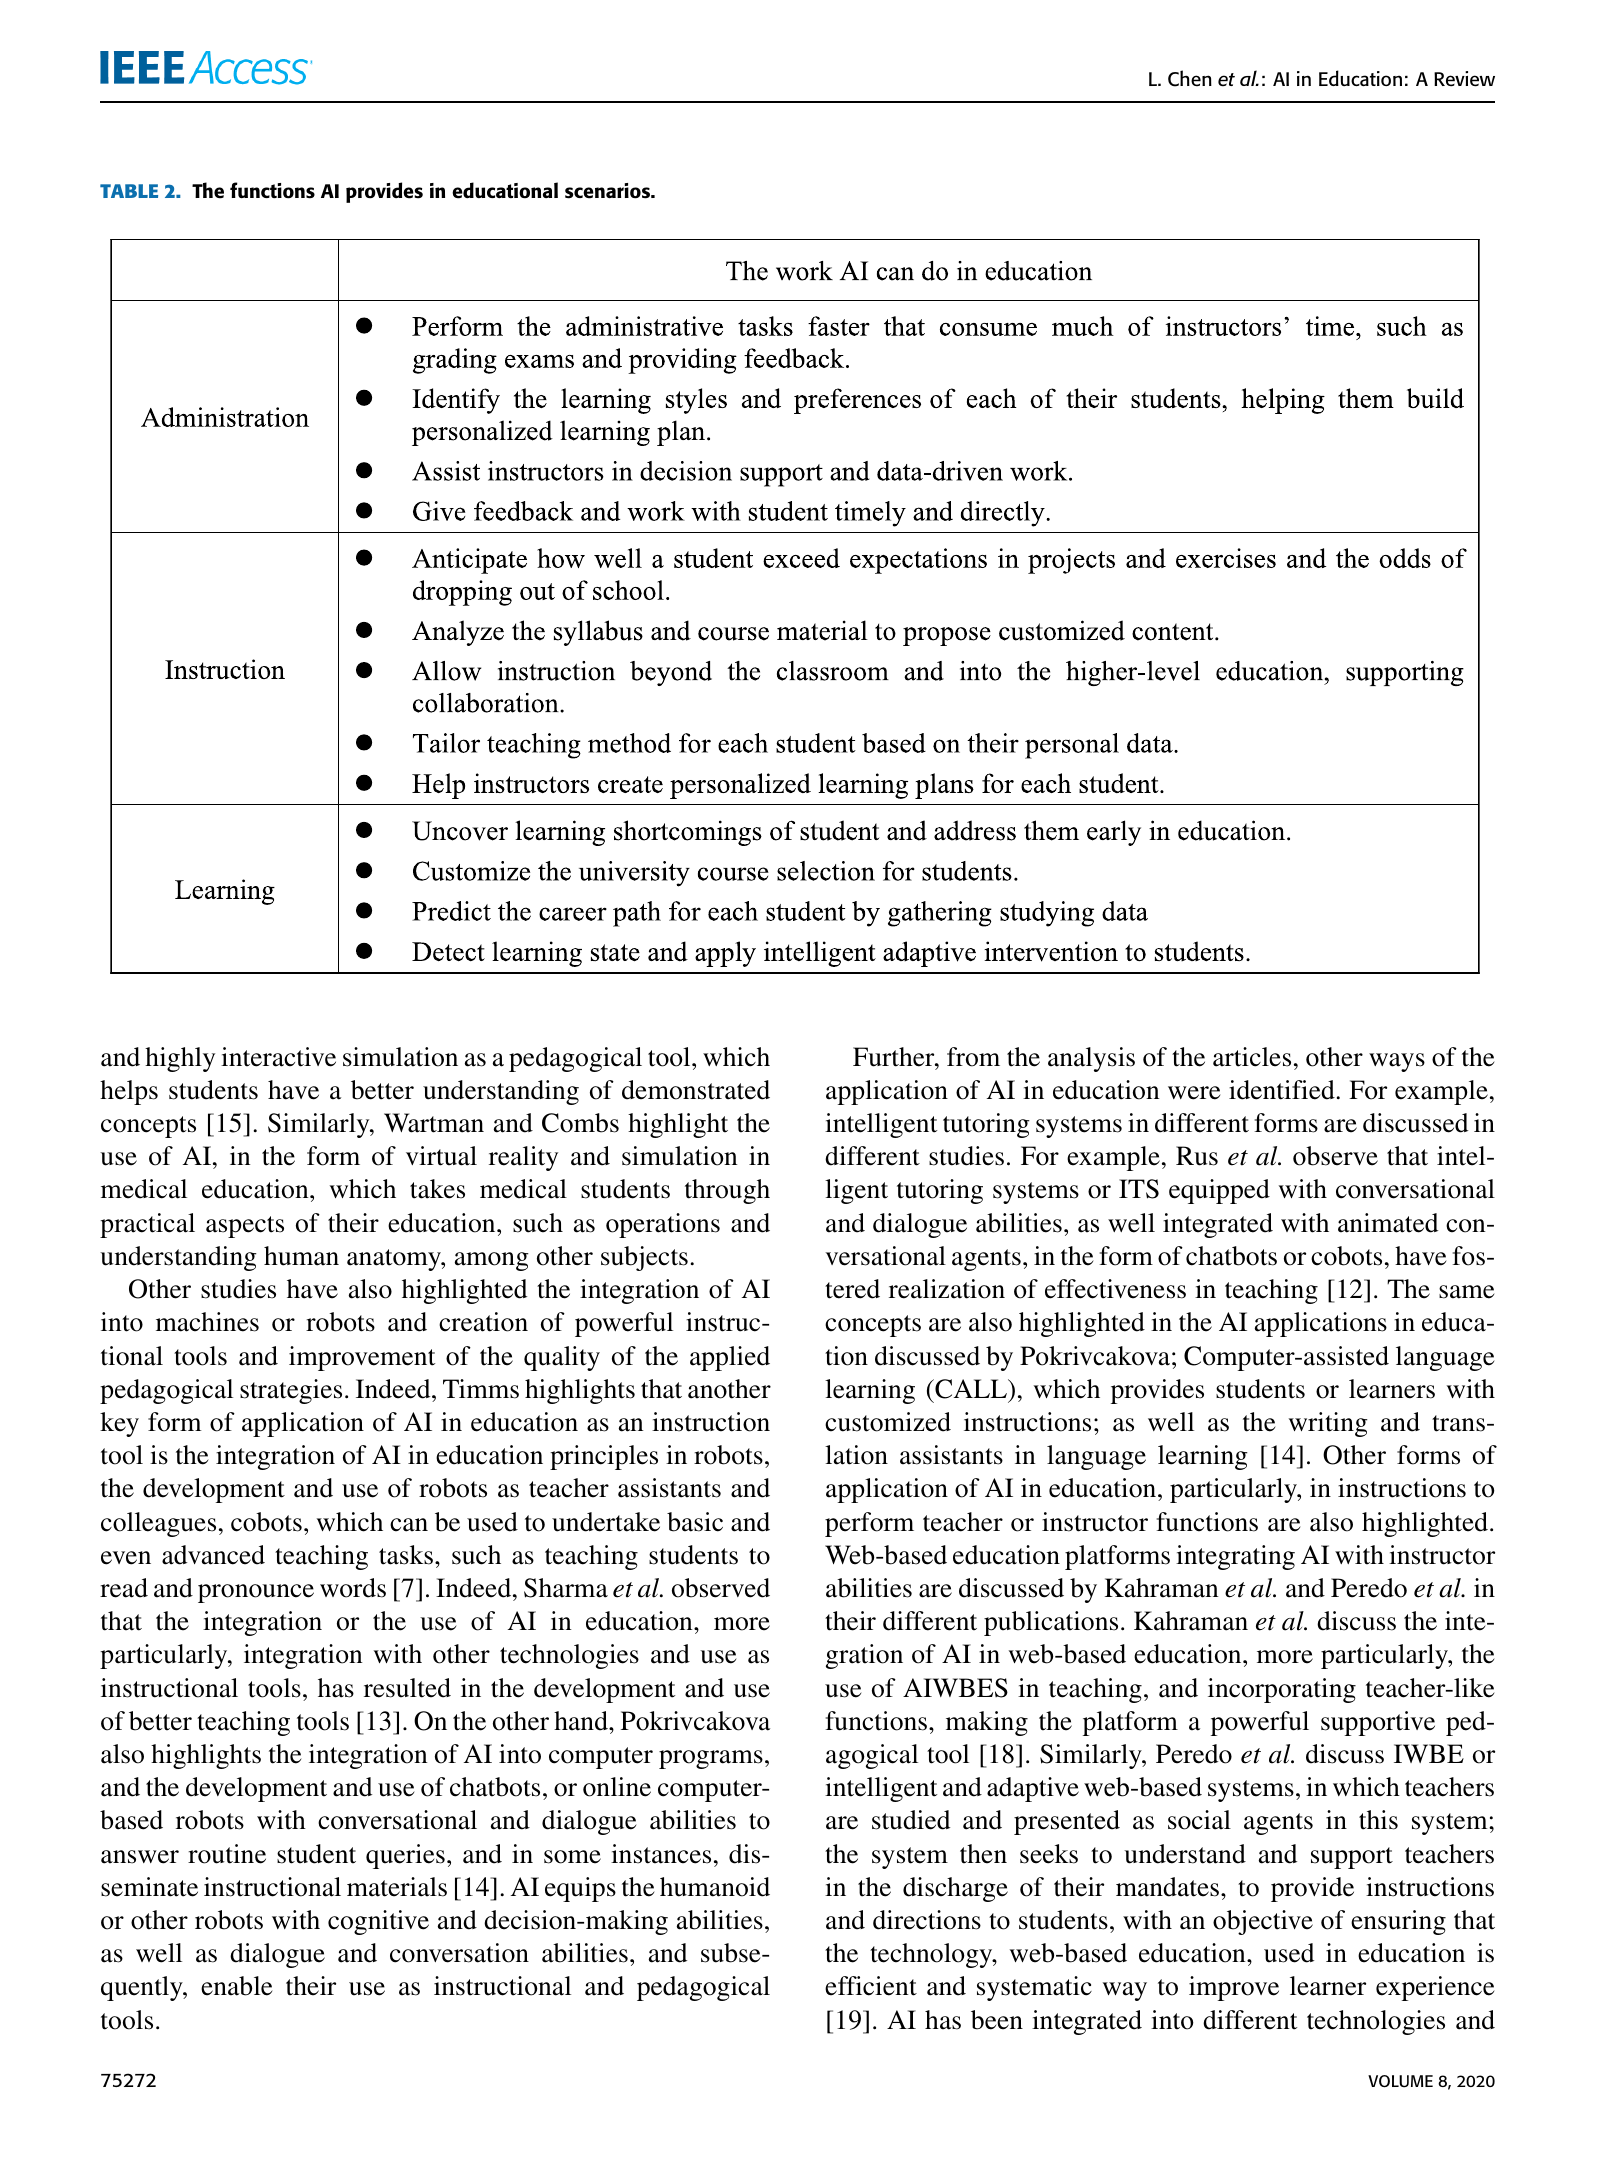

In [80]:
image = df.iloc[0]["base64"]
image = Image.open(io.BytesIO(base64.b64decode(image)))
image
